<a href="https://colab.research.google.com/github/AkramDOUKH/DeepLearningTensorFlow/blob/main/CNNTensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install grpcio==1.24.3
!pip install tensorflow==2.2.0

     |████████████████████████████████| 2.2 MB 2.6 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.44.0
    Uninstalling grpcio-1.44.0:
      Successfully uninstalled grpcio-1.44.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
     |████████████████████████████████| 516.2 MB 3.6 kB/s 
     |████████████████████████████████| 2.9 MB 28.8 MB/s 
     |████████████████████████████████| 3.0 MB 37.3 MB/s 
     |████████████████████████████████| 454 kB 48.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboar

In [2]:
import tensorflow as tf
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if not tf.__version__ == '2.2.0':
    printmd('<<<<<!!!!! ERROR !!!! please upgrade to TensorFlow 2.2.0, or restart your Kernel (Kernel->Restart & Clear Output)>>>>>')

In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [5]:
print(y_train[0:5])

[5 0 4 1 9]


In [6]:
print("categorical labels")
print(y_train[0:5])

# make labels one hot encoded
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

print("one hot encoded labels")
print(y_train[0:5])

categorical labels
[5 0 4 1 9]
one hot encoded labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(5, 10), dtype=float32)


In [7]:
print("number of training examples:" , x_train.shape[0])
print("number of test examples:" , x_test.shape[0])

number of training examples: 60000
number of test examples: 10000


In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(50)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(50)

In [9]:
# showing an example of the Flatten class and operation
from tensorflow.keras.layers import Flatten
flatten = Flatten(dtype='float32')

"original data shape"
print(x_train.shape)

"flattened shape"
print(flatten(x_train).shape)

(60000, 28, 28)
(60000, 784)


In [10]:
# Weight tensor
W = tf.Variable(tf.zeros([784, 10], tf.float32))
# Bias tensor
b = tf.Variable(tf.zeros([10], tf.float32))

In [11]:
# a sample softmax calculation on an input vector
vector = [10, 0.2, 8]
softmax = tf.nn.softmax(vector)
print("softmax calculation")
print(softmax.numpy())
print("verifying normalization")
print(tf.reduce_sum(softmax))
print("finding vector with largest value (label assignment)")
print("category", tf.argmax(softmax).numpy())

softmax calculation
[8.8075405e-01 4.8839214e-05 1.1919710e-01]
verifying normalization
tf.Tensor(1.0, shape=(), dtype=float32)
finding vector with largest value (label assignment)
category 0


In [16]:
def forward(x):
    return tf.matmul(x,W) + b

In [17]:
def activate(x):
    return tf.nn.softmax(forward(x))

In [18]:
def model(x):
    x = flatten(x)
    return activate(x)

In [19]:
def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))
# addition of 1e-10 to prevent errors in zero calculations

# current loss function for unoptimized model
cross_entropy(y_train, model(x_train)).numpy()

138155.0

In [20]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.25)

In [21]:
def train_step(x, y ):
    with tf.GradientTape() as tape:
        #compute loss function
        current_loss = cross_entropy( y, model(x))
        # compute gradient of loss 
        #(This is automatic! Even with specialized funcctions!)
        grads = tape.gradient( current_loss , [W,b] )
        # Apply SGD step to our Variables W and b
        optimizer.apply_gradients( zip( grads , [W,b] ) )     
    return current_loss.numpy()

In [22]:
# zeroing out weights in case you want to run this cell multiple times
# Weight tensor
W = tf.Variable(tf.zeros([784, 10],tf.float32))
# Bias tensor
b = tf.Variable(tf.zeros([10],tf.float32))

loss_values=[]
accuracies = []
epochs = 10

for i in range(epochs):
    j=0
    # each batch has 50 examples
    for x_train_batch, y_train_batch in train_ds:
        j+=1
        current_loss = train_step(x_train_batch, y_train_batch)
        if j%500==0: #reporting intermittent batch statistics
            print("epoch ", str(i), "batch", str(j), "loss:", str(current_loss) ) 
    
    # collecting statistics at each epoch...loss function and accuracy
    #  loss function
    current_loss = cross_entropy( y_train, model( x_train )).numpy()
    loss_values.append(current_loss)
    correct_prediction = tf.equal(tf.argmax(model(x_train), axis=1),
                                  tf.argmax(y_train, axis=1))
    #  accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    accuracies.append(accuracy)
    print("end of epoch ", str(i), "loss", str(current_loss), "accuracy", str(accuracy) ) 

epoch  0 batch 500 loss: 177.26141
epoch  0 batch 1000 loss: 174.39491
end of epoch  0 loss 223471.0 accuracy 0.8147
epoch  1 batch 500 loss: 153.2364
epoch  1 batch 1000 loss: 178.1075
end of epoch  1 loss 216641.61 accuracy 0.824
epoch  2 batch 500 loss: 209.28334
epoch  2 batch 1000 loss: 172.85431
end of epoch  2 loss 207265.33 accuracy 0.83315
epoch  3 batch 500 loss: 203.7942
epoch  3 batch 1000 loss: 152.35666
end of epoch  3 loss 210062.88 accuracy 0.8303
epoch  4 batch 500 loss: 189.21526
epoch  4 batch 1000 loss: 163.97006
end of epoch  4 loss 211364.31 accuracy 0.82985
epoch  5 batch 500 loss: 215.90894
epoch  5 batch 1000 loss: 175.0403
end of epoch  5 loss 202569.7 accuracy 0.83845
epoch  6 batch 500 loss: 200.97389
epoch  6 batch 1000 loss: 167.53844
end of epoch  6 loss 207683.56 accuracy 0.83435
epoch  7 batch 500 loss: 200.98653
epoch  7 batch 1000 loss: 185.46494
end of epoch  7 loss 200680.2 accuracy 0.8413333
epoch  8 batch 500 loss: 213.95403
epoch  8 batch 1000 lo

In [23]:
correct_prediction_train = tf.equal(tf.argmax(model(x_train), axis=1),tf.argmax(y_train,axis=1))
accuracy_train = tf.reduce_mean(tf.cast(correct_prediction_train, tf.float32)).numpy()

correct_prediction_test = tf.equal(tf.argmax(model(x_test), axis=1),tf.argmax(y_test, axis=1))
accuracy_test = tf.reduce_mean(tf.cast(correct_prediction_test, tf.float32)).numpy()

print("training accuracy", accuracy_train)
print("test accuracy", accuracy_test)

training accuracy 0.84305
test accuracy 0.8355


Text(0, 0.5, 'loss')

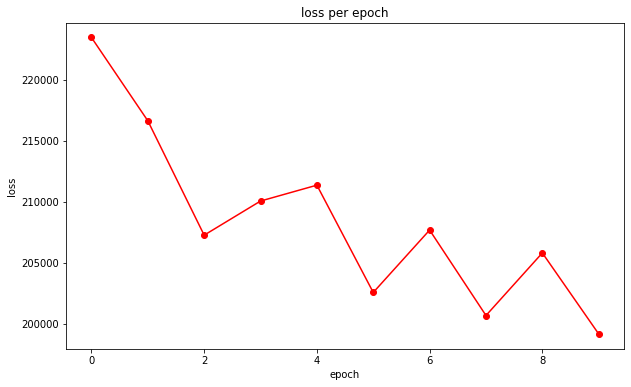

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
#print(loss_values)
plt.plot(loss_values,'-ro')
plt.title("loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0, 0.5, 'accuracy')

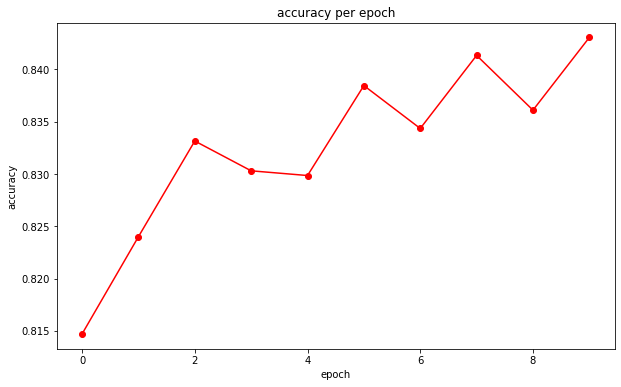

In [25]:
plt.plot(accuracies,'-ro')
plt.title("accuracy per epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [26]:
width = 28 # width of the image in pixels 
height = 28 # height of the image in pixels
flat = width * height # number of pixels in one image 
class_output = 10 # number of possible classifications for the problem

In [27]:
x_image_train = tf.reshape(x_train, [-1,28,28,1])  
x_image_train = tf.cast(x_image_train, 'float32') 

x_image_test = tf.reshape(x_test, [-1,28,28,1]) 
x_image_test = tf.cast(x_image_test, 'float32') 

#creating new dataset with reshaped inputs
train_ds2 = tf.data.Dataset.from_tensor_slices((x_image_train, y_train)).batch(50)
test_ds2 = tf.data.Dataset.from_tensor_slices((x_image_test, y_test)).batch(50)

In [28]:
x_image_train = tf.slice(x_image_train,[0,0,0,0],[10000, 28, 28, 1])
y_train = tf.slice(y_train,[0,0],[10000, 10])

In [29]:
W_conv1 = tf.Variable(tf.random.truncated_normal([5, 5, 1, 32], stddev=0.1, seed=0))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # need 32 biases for 32 outputs

In [30]:
def convolve1(x):
    return(
        tf.nn.conv2d(x, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)

In [31]:
def h_conv1(x): return(tf.nn.relu(convolve1(x)))

In [32]:
def conv1(x):
    return tf.nn.max_pool(h_conv1(x), ksize=[1, 2, 2, 1], 
                          strides=[1, 2, 2, 1], padding='SAME')

In [33]:
W_conv2 = tf.Variable(tf.random.truncated_normal([5, 5, 32, 64], stddev=0.1, seed=1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64])) #need 64 biases for 64 outputs

In [34]:
def convolve2(x): 
    return( 
    tf.nn.conv2d(conv1(x), W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)

In [35]:
def h_conv2(x):  return tf.nn.relu(convolve2(x))

In [36]:
def conv2(x):  
    return(
    tf.nn.max_pool(h_conv2(x), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'))

In [37]:
def layer2_matrix(x): return tf.reshape(conv2(x), [-1, 7 * 7 * 64])

In [38]:
W_fc1 = tf.Variable(tf.random.truncated_normal([7 * 7 * 64, 1024], stddev=0.1, seed = 2))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024])) # need 1024 biases for 1024 outputs

In [39]:
def fcl(x): return tf.matmul(layer2_matrix(x), W_fc1) + b_fc1

In [40]:
def h_fc1(x): return tf.nn.relu(fcl(x))

In [41]:
keep_prob=0.5
def layer_drop(x): return tf.nn.dropout(h_fc1(x), keep_prob)

In [42]:
W_fc2 = tf.Variable(tf.random.truncated_normal([1024, 10], stddev=0.1, seed = 2)) #1024 neurons
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10])) # 10 possibilities for digits [0,1,2,3,4,5,6,7,8,9]

In [43]:
def fc(x): return tf.matmul(layer_drop(x), W_fc2) + b_fc2

In [44]:
def y_CNN(x): return tf.nn.softmax(fc(x))

In [45]:
def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))

In [46]:
optimizer = tf.keras.optimizers.Adam(1e-4)

In [47]:
variables = [W_conv1, b_conv1, W_conv2, b_conv2, 
             W_fc1, b_fc1, W_fc2, b_fc2, ]

def train_step(x, y):
    with tf.GradientTape() as tape:
        current_loss = cross_entropy( y, y_CNN( x ))
        grads = tape.gradient( current_loss , variables )
        optimizer.apply_gradients( zip( grads , variables ) )
        return current_loss.numpy()


In [48]:
correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1), tf.argmax(y_train, axis=1))

In [49]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float32'))

In [50]:
loss_values=[]
accuracies = []
epochs = 1

for i in range(epochs):
    j=0
    # each batch has 50 examples
    for x_train_batch, y_train_batch in train_ds2:
        j+=1
        current_loss = train_step(x_train_batch, y_train_batch)
        if j%50==0: #reporting intermittent batch statistics
            correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                  tf.argmax(y_train_batch, axis=1))
            #  accuracy
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
            print("epoch ", str(i), "batch", str(j), "loss:", str(current_loss),
                     "accuracy", str(accuracy)) 
            
    current_loss = cross_entropy( y_train, y_CNN( x_image_train )).numpy()
    loss_values.append(current_loss)
    correct_prediction = tf.equal(tf.argmax(y_CNN(x_image_train), axis=1),
                                  tf.argmax(y_train, axis=1))
    #  accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    accuracies.append(accuracy)
    print("end of epoch ", str(i), "loss", str(current_loss), "accuracy", str(accuracy) )  

epoch  0 batch 50 loss: 109.797516 accuracy 0.4
epoch  0 batch 100 loss: 65.831215 accuracy 0.6
epoch  0 batch 150 loss: 34.790802 accuracy 0.7
epoch  0 batch 200 loss: 18.548124 accuracy 0.86
epoch  0 batch 250 loss: 31.095512 accuracy 0.76
epoch  0 batch 300 loss: 30.44116 accuracy 0.84
epoch  0 batch 350 loss: 23.772108 accuracy 0.84
epoch  0 batch 400 loss: 22.767494 accuracy 0.82
epoch  0 batch 450 loss: 31.026342 accuracy 0.8
epoch  0 batch 500 loss: 14.258637 accuracy 0.9
epoch  0 batch 550 loss: 24.449802 accuracy 0.92
epoch  0 batch 600 loss: 27.806889 accuracy 0.9
epoch  0 batch 650 loss: 22.76064 accuracy 0.88
epoch  0 batch 700 loss: 6.6120014 accuracy 0.92
epoch  0 batch 750 loss: 21.450972 accuracy 0.86
epoch  0 batch 800 loss: 16.278614 accuracy 0.88
epoch  0 batch 850 loss: 19.77332 accuracy 0.92
epoch  0 batch 900 loss: 10.344086 accuracy 0.94
epoch  0 batch 950 loss: 12.12477 accuracy 0.92
epoch  0 batch 1000 loss: 15.946089 accuracy 0.92
epoch  0 batch 1050 loss: 4.7

In [51]:
j=0
acccuracies=[]
# evaluate accuracy by batch and average...reporting every 100th batch
for x_train_batch, y_train_batch in train_ds2:
        j+=1
        correct_prediction = tf.equal(tf.argmax(y_CNN(x_train_batch), axis=1),
                                  tf.argmax(y_train_batch, axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
        #accuracies.append(accuracy)
        if j%100==0:
            print("batch", str(j), "accuracy", str(accuracy) ) 
import numpy as np
print("accuracy of entire set", str(np.mean(accuracies)))        

batch 100 accuracy 0.96
batch 200 accuracy 0.92
batch 300 accuracy 0.92
batch 400 accuracy 1.0
batch 500 accuracy 0.98
batch 600 accuracy 0.9
batch 700 accuracy 0.96
batch 800 accuracy 0.94
batch 900 accuracy 0.92
batch 1000 accuracy 0.94
batch 1100 accuracy 0.82
batch 1200 accuracy 1.0
accuracy of entire set 0.9411


In [52]:
kernels = tf.reshape(tf.transpose(W_conv1, perm=[2, 3, 0,1]),[32, -1])

--2022-03-12 16:39:09--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0120EN-SkillsNetwork/labs/Week2/data/utils.py
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5097 (5.0K) [text/x-python]
Saving to: ‘utils1.py’

utils1.py           100%[===================>]   4.98K  --.-KB/s    in 0s      

2022-03-12 16:39:10 (606 MB/s) - ‘utils1.py’ saved [5097/5097]



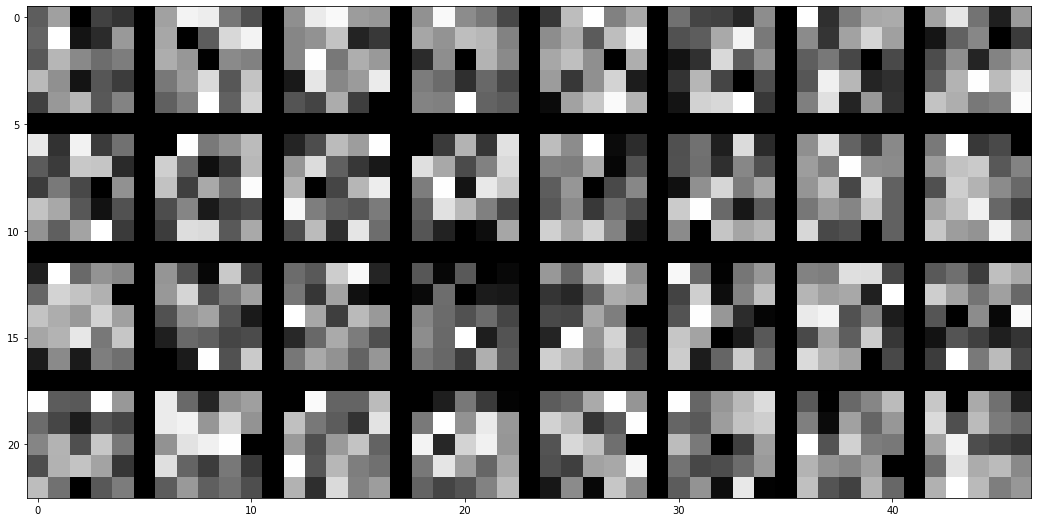

In [53]:
!wget --output-document utils1.py https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0120EN-SkillsNetwork/labs/Week2/data/utils.py
import utils1
import imp
imp.reload(utils1)
from utils1 import tile_raster_images
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
image = Image.fromarray(tile_raster_images(kernels.numpy(), img_shape=(5, 5) ,tile_shape=(4, 8), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

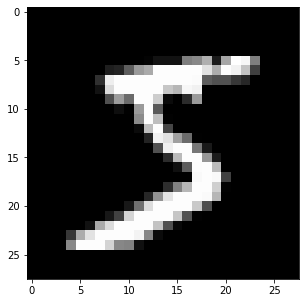

In [54]:
import numpy as np
plt.rcParams['figure.figsize'] = (5.0, 5.0)
sampleimage = [x_image_train[0]]
plt.imshow(np.reshape(sampleimage,[28,28]), cmap="gray")

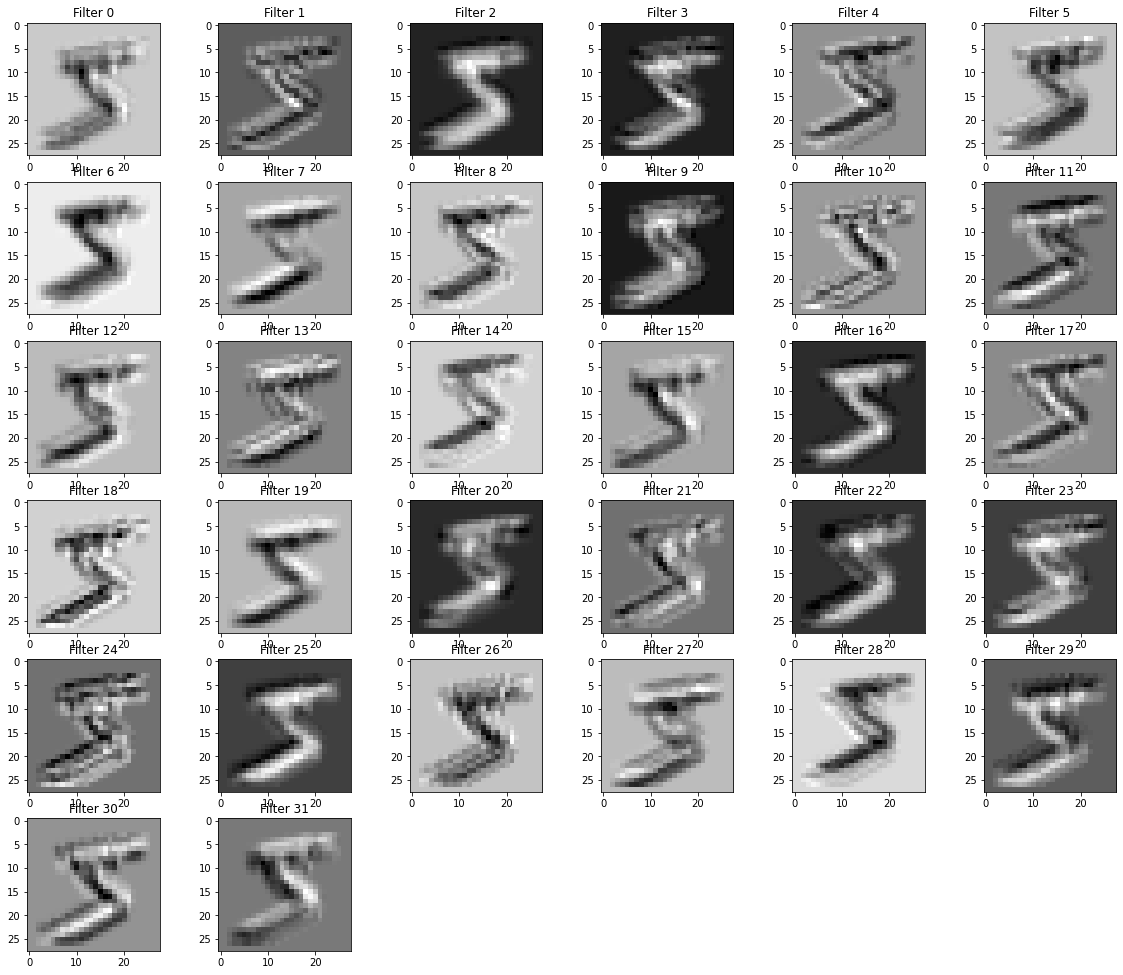

In [55]:
#ActivatedUnits = sess.run(convolve1,feed_dict={x:np.reshape(sampleimage,[1,784],order='F'),keep_prob:1.0})
keep_prob=1.0
ActivatedUnits = convolve1(sampleimage)
                           
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 6
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")

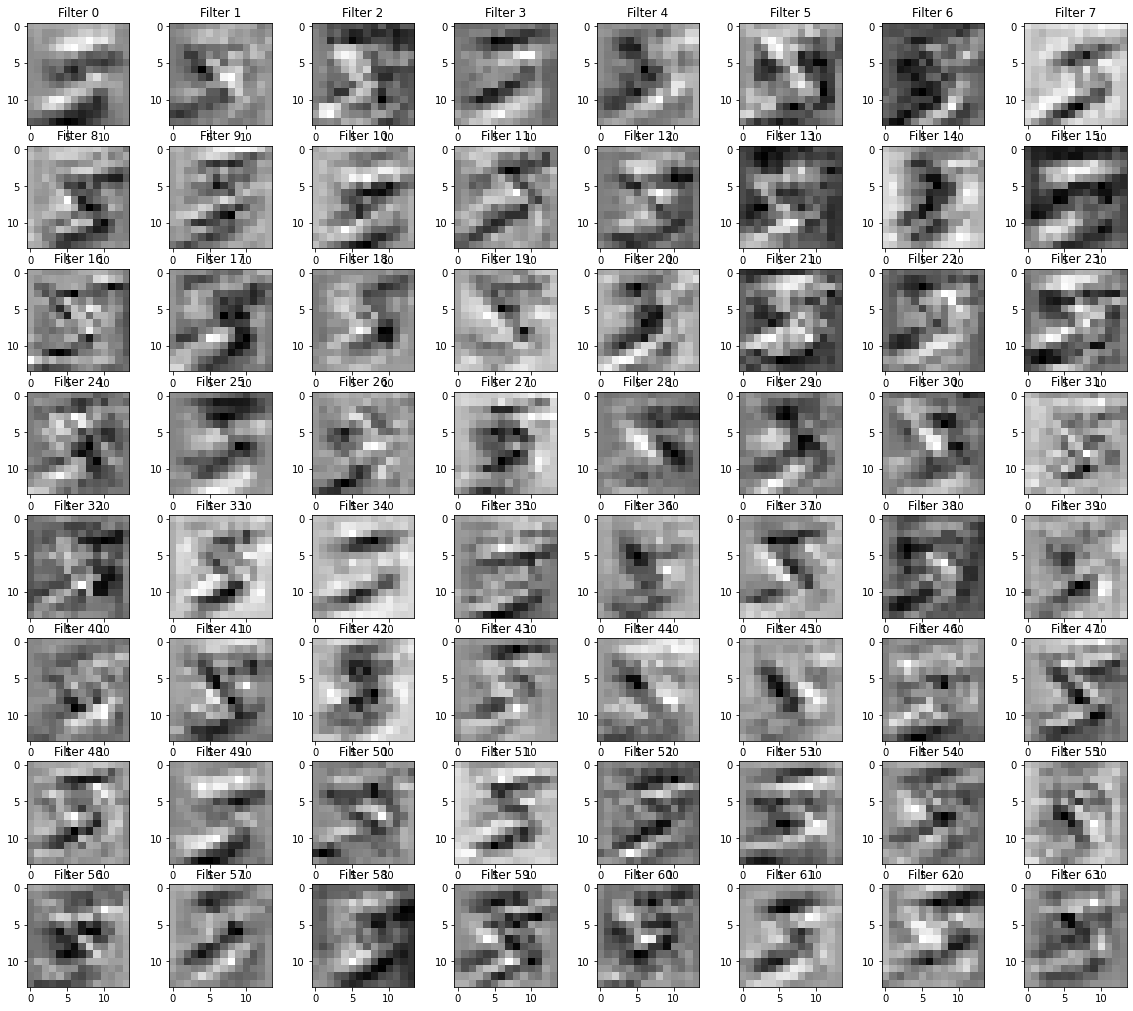

In [56]:
#ActivatedUnits = sess.run(convolve2,feed_dict={x:np.reshape(sampleimage,[1,784],order='F'),keep_prob:1.0})
ActivatedUnits = convolve2(sampleimage)
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 8
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i))
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")